# Corporación Favorita Grocery Sales Forecasting

### Exploratory Data Analysis

This workbook look at the transaction data to understand the sales trend as it relates to items, clusters of stores, geographic region, and seasonality.  

In [162]:
#devtools::session_info()

In [1]:
# load library
library(data.table)
library(dplyr)
library(lubridate)
library(zoo)
library(ggplot2)
library(repr)
library(grid) # for multiplot
library(scales) # for date plotting
library(timetk)     # Toolkit for working with time series in R
library(quantmod)
library(tidyquant)
library(treemapify)
library(sweep)
library(forecast)
library(fpp2)
library(prophet);


Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    date


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: xts

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last

The following objects are masked from 'package:data.table':

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: PerformanceAnalytics

Attaching packag

ERROR: Error in library(treemapify): there is no package called 'treemapify'


In [6]:
# load datasets
train <- readRDS(paste0(getwd(), '/data/train.rds'))
subsetItems <- readRDS(paste0(getwd(),'/data/subsetItems.rds'))
subsetStores <-readRDS(paste0(getwd(),'/data/subsetStores.rds'))
items <- readRDS(paste0(getwd(),'/data/items.rds'))
transactions <- readRDS(paste0(getwd(),'/data/transactions.rds'))
stores <- readRDS(paste0(getwd(),'/data/stores.rds'))

In [9]:
# set chart plotting area
options(repr.plot.width= 5.5, repr.plot.height= 4)

In [10]:
# user-defined function for plotting
# source http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)
source('scripts/multiplot.R')

In [11]:
theme = theme_set(theme_light())
theme = theme_update(legend.position="bottom")

### Which store generates the biggest unit_sales and the most transactions?

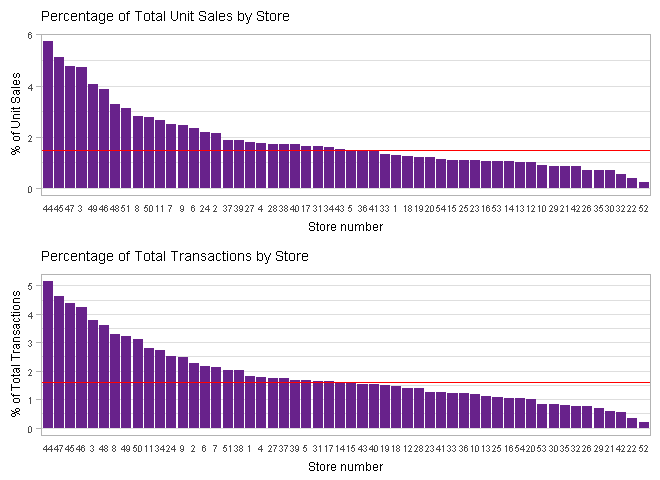

In [12]:
chartData <- train %>%
  group_by(store_nbr) %>%
  summarize(totalSale = sum(unit_sales)) %>%
  mutate(percentageSale = totalSale/sum(totalSale)*100)

chart1 <- chartData %>%
  ggplot(aes(x = reorder(as.factor(store_nbr), -percentageSale), y = percentageSale)) +
  geom_bar(stat = 'identity', fill = 'darkorchid4') + 
  labs(y = '% of Unit Sales', x = 'Store number', title = 'Percentage of Total Unit Sales by Store') +
  theme(text = element_text(size= 7),
        axis.ticks.x= element_blank(),
        panel.grid.major.x = element_blank()) + 
  geom_hline(aes(yintercept = median(percentageSale)), colour = 'red')

chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  mutate(percentageTotal = total/sum(total)*100) %>%
  arrange(-percentageTotal)

chart2 <- chartData %>%
  ggplot(aes(x = reorder(as.factor(store_nbr), -percentageTotal), y = percentageTotal)) +
  geom_bar(stat = 'identity', fill = 'darkorchid4') + 
  labs(y = '% of Total Transactions', x = 'Store number', title = 'Percentage of Total Transactions by Store') +
  theme(text = element_text(size= 7),
        axis.ticks.x= element_blank(),
        panel.grid.major.x = element_blank()) + 
  geom_hline(aes(yintercept = median(percentageTotal)), colour = 'red')

layout <- matrix(c(1,2),2,1,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)


### Does unit_sale corresponds to number of transactions? 
Unit sales correlates with the number of transactions.  In addition, the type of store seem to also correpond with number of transactions.  

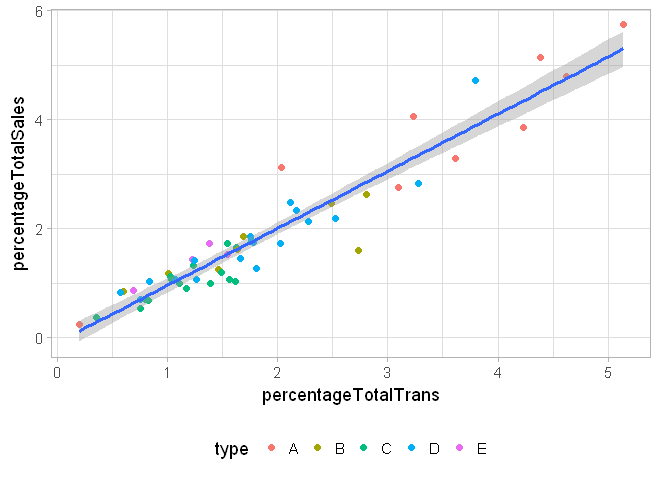

In [13]:
sales <- train %>%
  group_by(store_nbr) %>%
  summarize(total = sum(unit_sales)) %>%
  mutate(percentageTotalSales = total/sum(total)*100)
chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  mutate(percentageTotalTrans = total/sum(total)*100) %>%
  left_join(sales, by = "store_nbr")

chart <- chartData %>%
  ggplot(aes(x = percentageTotalTrans, y = percentageTotalSales)) +
  geom_point(aes(color = type)) + 
  #geom_text(label= chartData$store_nbr) +
  geom_smooth(method="lm", se=TRUE, fullrange=FALSE, level=0.95) +
  theme(legend.position="bottom")

chart

### What is the start date of the stores?

In [14]:
chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(startDate = min(date)) %>%
  arrange(desc(startDate)) 
head(chartData, 10)

store_nbr,type,cluster,city,state,startDate
52,A,11,Manta,Manabi,2017-04-20
22,C,7,Puyo,Pastaza,2015-10-09
42,D,2,Cuenca,Azuay,2015-08-21
21,B,6,Santo Domingo,Santo Domingo de los Tsachilas,2015-07-24
29,E,10,Guayaquil,Guayas,2015-03-20
20,B,6,Quito,Pichincha,2015-02-13
53,D,13,Manta,Manabi,2014-05-29
36,E,10,Libertad,Guayas,2013-05-09
1,D,13,Quito,Pichincha,2013-01-02
10,C,15,Quito,Pichincha,2013-01-02


### Does store type have to do with average daily transaction?

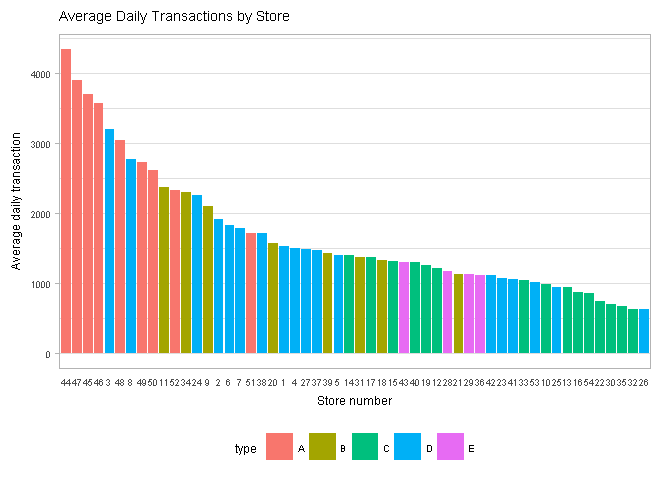

In [15]:
chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(average = mean(transactions)) %>%
  arrange(desc(average)) 

chart <- chartData %>%
  ggplot(aes(x = reorder(as.factor(store_nbr), -average), 
             y = average, 
             group = type, 
             fill = type)) +
  geom_bar(stat = 'identity') + 
  labs(y = 'Average daily transaction', x = 'Store number', title = 'Average Daily Transactions by Store') +
  theme(text = element_text(size= 7),
        axis.ticks.x= element_blank(),
        panel.grid.major.x = element_blank())

chart

### What is the relationship between store type and clusters?

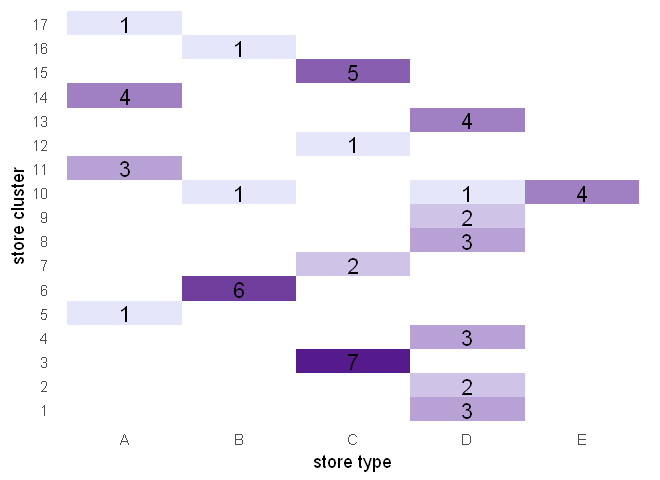

In [16]:
chartData <- transactions %>%
  select(store_nbr, type, cluster) %>%
  group_by(type, cluster) %>%
  summarize(n = n_distinct(store_nbr))

chartData$cluster <- as.factor(chartData$cluster)
chartData$cluster <- factor(chartData$cluster, levels = order(levels(chartData$cluster)))

chart <- chartData %>%
  ggplot(aes(x = type, y = cluster)) +
  geom_tile(aes(fill = n)) +
  labs(x = "store type", y = "store cluster") +
  scale_fill_gradient(low = 'lavender', high= 'purple4') + 
  geom_text(aes(label = n, size=2.5)) +
  theme_minimal() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank())

chart

#stores$cluster <- as.factor(stores$cluster)
#stores$cluster <- factor(stores$cluster, levels = order(levels(stores$cluster)))
#chart <- stores %>%
#  ggplot(aes(x = type, 
#             y = cluster)) +
#  labs(x = "store type", y = "store cluster") +
#  scale_fill_gradient(low = 'lavender', high= 'purple4') + 
#geom_bin2d()

#chart

### Are clusters related to average daily transaction?
Seem to be related.  Store 44 seem to be a super store with its own cluster.  Cluster 4 are smaller stores with lower transactions.  

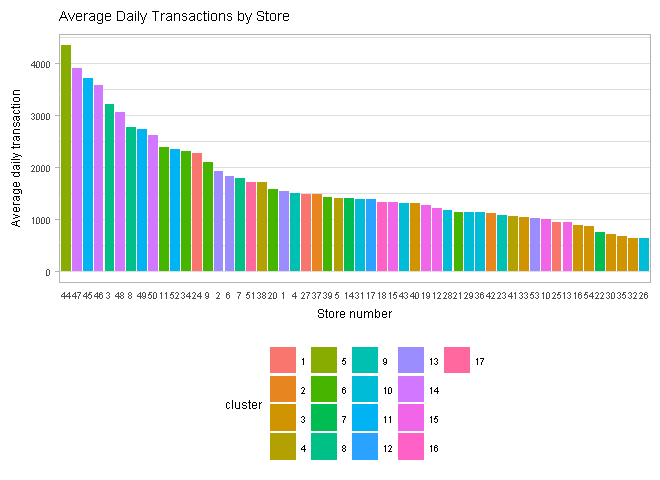

In [17]:
chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(average = mean(transactions)) %>%
  arrange(desc(average)) 

chartData$cluster <- as.factor(chartData$cluster)
chartData$cluster <- factor(chartData$cluster, levels = order(levels(chartData$cluster)))

chart <- chartData %>%
  ggplot(aes(x = reorder(as.factor(store_nbr), -average), 
             y = average, 
             group = cluster, 
             fill = cluster)) +
  geom_bar(stat = 'identity') + 
  labs(y = 'Average daily transaction', x = 'Store number', title = 'Average Daily Transactions by Store') +
  theme(text = element_text(size= 7),
        axis.ticks.x= element_blank(),
        panel.grid.major.x = element_blank())

chart

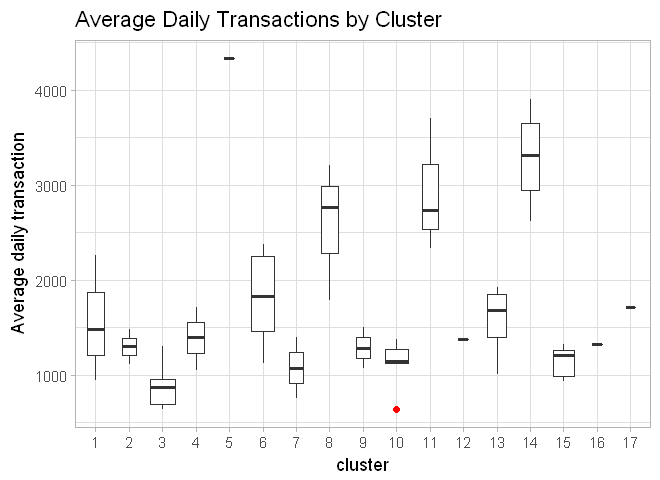

In [18]:
chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(average = mean(transactions)) %>%
  arrange(desc(average)) 

chartData$cluster <- as.factor(chartData$cluster)
chartData$cluster <- factor(chartData$cluster, levels = order(levels(chartData$cluster)))

chart <- chartData %>%
  ggplot(aes(x = cluster, 
             y = average))+
  geom_boxplot(outlier.color = "red", varwidth = TRUE)+
  labs(y = 'Average daily transaction', x = 'cluster', title = 'Average Daily Transactions by Cluster')

chart

### Are clusters more related to cities/states?
Clusters do not seem to be related to geography

In [19]:
chartData <- transactions %>%
  group_by(store_nbr, type, cluster, city, state) %>%
  summarize(average = mean(transactions)) %>%
  arrange(desc(average))
chartData$cluster <- as.factor(chartData$cluster)
chartData$cluster <- factor(chartData$cluster, levels = order(levels(chartData$cluster)))
table(chartData$state, chartData$cluster)
table(chartData$city, chartData$cluster)

                                
                                 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
  Azuay                          0 2 0 0 0 1 0 0 0  0  0  0  0  0  0  0  0
  Bolivar                        0 0 0 0 0 0 0 0 0  0  0  0  0  0  1  0  0
  Chimborazo                     0 0 0 0 0 0 1 0 0  0  0  0  0  0  0  0  0
  Cotopaxi                       0 0 0 0 0 0 0 0 0  0  0  0  0  0  2  0  0
  El Oro                         0 0 1 1 0 0 0 0 0  0  0  0  0  0  0  0  0
  Esmeraldas                     0 0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  0
  Guayas                         2 0 3 0 0 1 0 0 0  4  0  0  0  0  0  0  1
  Imbabura                       0 0 0 0 0 0 0 0 0  0  0  0  0  0  1  0  0
  Loja                           0 0 0 1 0 0 0 0 0  0  0  0  0  0  0  0  0
  Los Rios                       0 0 1 0 0 0 0 0 0  1  0  0  0  0  0  0  0
  Manabi                         0 0 1 0 0 0 0 0 0  0  1  0  1  0  0  0  0
  Pastaza                        0 0 0 0 0 0 1 0 0  0  0  0  0  0  

               
                1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
  Ambato        0 0 0 0 0 0 0 0 1  0  0  0  0  1  0  0  0
  Babahoyo      0 0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  0
  Cayambe       0 0 0 0 0 1 0 0 0  0  0  0  0  0  0  0  0
  Cuenca        0 2 0 0 0 1 0 0 0  0  0  0  0  0  0  0  0
  Daule         1 0 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0
  El Carmen     0 0 1 0 0 0 0 0 0  0  0  0  0  0  0  0  0
  Esmeraldas    0 0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  0
  Guaranda      0 0 0 0 0 0 0 0 0  0  0  0  0  0  1  0  0
  Guayaquil     1 0 2 0 0 1 0 0 0  3  0  0  0  0  0  0  1
  Ibarra        0 0 0 0 0 0 0 0 0  0  0  0  0  0  1  0  0
  Latacunga     0 0 0 0 0 0 0 0 0  0  0  0  0  0  2  0  0
  Libertad      0 0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  0
  Loja          0 0 0 1 0 0 0 0 0  0  0  0  0  0  0  0  0
  Machala       0 0 1 1 0 0 0 0 0  0  0  0  0  0  0  0  0
  Manta         0 0 0 0 0 0 0 0 0  0  1  0  1  0  0  0  0
  Playas        0 0 1 0 0 0 0 0 0  0  0  0  0  0  0  0  

### Which city/state generated the most transactions?

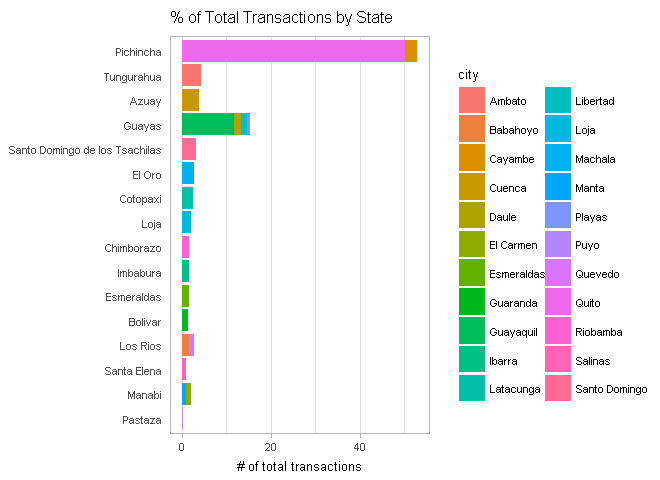

In [20]:
chartData <- transactions %>%
  select(transactions, city, state) %>%
  group_by(city, state) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  mutate(percentage = total/sum(total)*100) %>%
  arrange(-percentage)

#head(chartData)

chart <- chartData %>%
  ggplot(aes(x = reorder(as.factor(state), percentage), 
             y = percentage)) +
  geom_bar(stat = 'identity', aes(fill = city, group = state))+
  labs(y = '# of total transactions', x = '', title = '% of Total Transactions by State') +
  theme(text = element_text(size=8),
        panel.grid.major.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        legend.position = "right")+
        #axis.text.x = element_text(angle = 90, hjust = 1)) +
  coord_flip()


chart

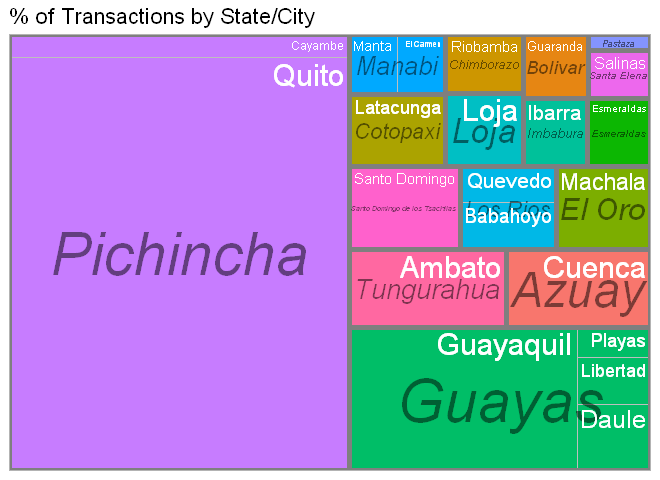

In [24]:
chartData <- transactions %>%
  select(transactions, city, state) %>%
  group_by(city, state) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  mutate(percentage = total/sum(total)*100) %>%
  arrange(-percentage)

chart <- chartData %>%
  ggplot(aes(area = percentage, fill = state, label = city, subgroup = state)) +
  geom_treemap() + 
  geom_treemap_subgroup_border() +
  geom_treemap_subgroup_text(place = "centre", alpha = 0.5, colour =
                             "black", fontface = "italic", min.size = 4) +
  geom_treemap_text(colour = "white", place = "topright") +
  theme(legend.position = "null") +
  ggtitle("% of Transactions by State/City")

chart

### Which product category generates the most unit_sales?

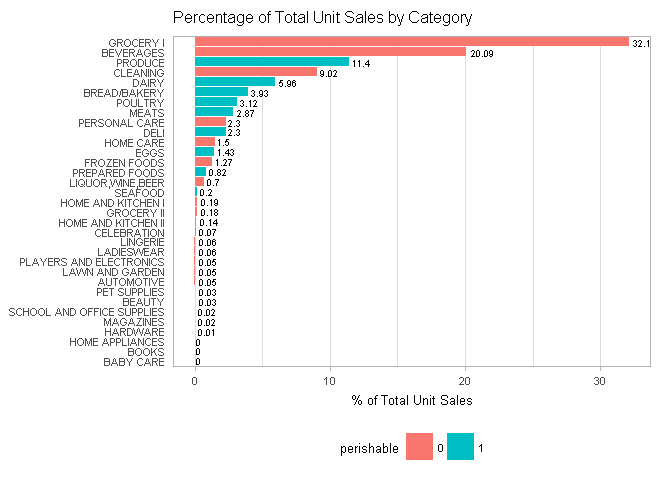

In [25]:
total <- sum(train$unit_sales)
chartData<- train %>%
  group_by(perishable, family) %>%
  summarize(totalSale = sum(unit_sales)) %>%
  mutate(percentageSale = round(totalSale/total*100, 2))

chartData$perishable = as.character(chartData$perishable)

chart<- chartData %>%
  ggplot(aes(x = reorder(as.factor(family), percentageSale), 
             y = percentageSale,
             group = perishable,
             fill = perishable,
             )) +
  geom_bar(stat = 'identity') + 
  geom_text(aes(label=percentageSale), size = 2, hjust = -0.2) +
  labs(y = '% of Total Unit Sales', x = '', title = 'Percentage of Total Unit Sales by Category') +
  theme(text = element_text(size=8),
        panel.grid.major.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()) +
  coord_flip()

chart

### What is the unit_sales breakdown between perishable and non-perishable items?

In [26]:
chartData <- train %>%
    group_by(perishable) %>%
    summarize(totalSale = sum(unit_sales)) %>%
    mutate(percentageSale = totalSale/sum(totalSale)*100) %>%
    select(-totalSale)

chartData

perishable,percentageSale
0,67.97878
1,32.02122


### What are the products with with highest unit_sales?

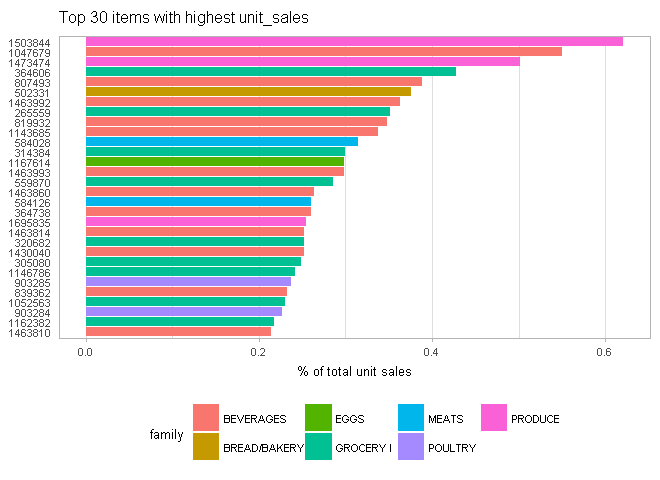

In [27]:
chartData <- train %>%
  group_by(item_nbr, family) %>%
  summarize(totalSale = sum(unit_sales)) %>%
  ungroup() %>%
  mutate(percentageSale = totalSale/sum(totalSale)*100) %>%
  top_n(c(30), percentageSale)

chart <- chartData %>%
  ggplot(aes(x = reorder(as.factor(item_nbr), percentageSale), 
             y = percentageSale,
             group = family,
             fill = family)) +
  geom_bar(stat = 'identity') + 
  labs(y = '% of total unit sales', x = 'Item number', title = 'Top 30 items with highest unit_sales') +
  theme(text = element_text(size=8),
        panel.grid.major.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        legend.title.align = 1) +
  coord_flip()
chart

### Does different store type sell different family of products?

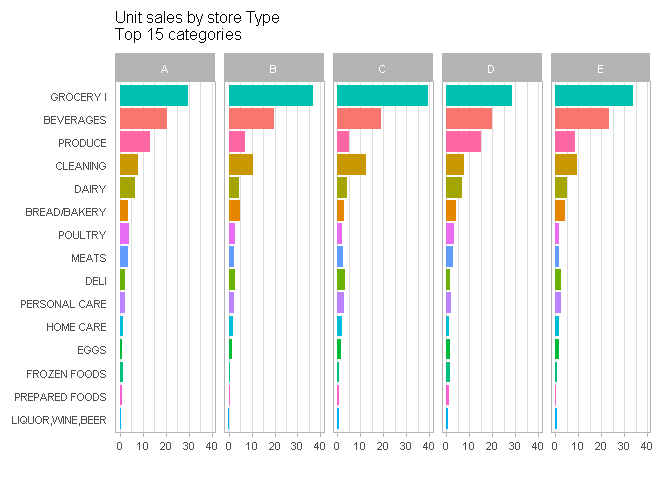

In [28]:
chartData <- train %>%
  group_by(type, family) %>%
  summarize(totalSale = sum(unit_sales)) %>%
  mutate(percentageSale = totalSale/sum(totalSale)*100) %>%
  arrange(type, -percentageSale) %>%
  top_n(15, percentageSale)
  
chart <- chartData %>%
  ggplot(aes(x = reorder(as.factor(family), percentageSale), 
             y = percentageSale,
             group = family,
             fill = family)) +
  geom_bar(stat = 'identity') + 
  facet_grid(. ~ type) + 
  labs(y = '', x = '', title = 'Unit sales by store Type\nTop 15 categories') +
  theme(text = element_text(size=8),
        axis.ticks.y= element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.y= element_blank()) +
  coord_flip() +  
  guides(fill=FALSE)

chart


### Zooming in on the product families that have lowest unit_sales

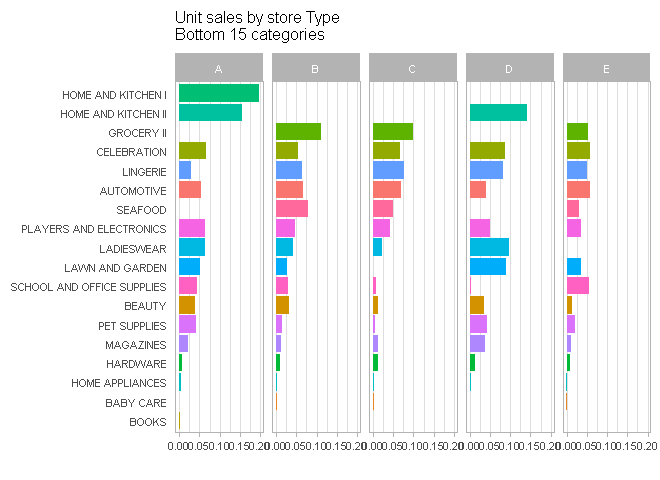

In [29]:
chartData <- train %>%
  group_by(type, family) %>%
  summarize(totalSale = sum(unit_sales)) %>%
  mutate(percentageSale = totalSale/sum(totalSale)*100) %>%
  arrange(type, percentageSale) %>%
  top_n(-15, percentageSale)

chart <- chartData %>%
  ggplot(aes(x = reorder(as.factor(family), percentageSale), 
             y = percentageSale,
             group = family,
             fill = family)) +
  geom_bar(stat = 'identity') + 
  facet_grid(. ~ type) + 
  labs(y = '', x = '', title = 'Unit sales by store Type\nBottom 15 categories') +
  theme(text = element_text(size=8),
        axis.ticks.y= element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.y= element_blank()) +
  coord_flip() + 
  guides(fill=FALSE)

chart

### Does every year have similar seasonality?

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."

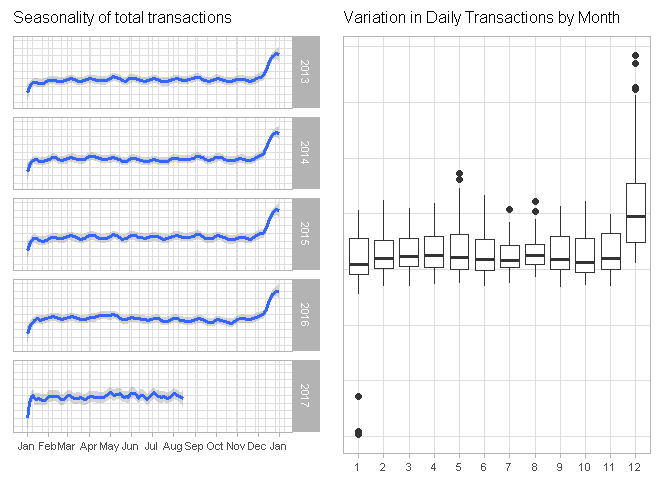

In [36]:
chartData <- transactions %>%
  select(date, transactions) %>%
  group_by(date) %>%
  summarize(total = sum(transactions)) %>%
  mutate(year = year(date)) %>%
  mutate(day = yday(date)) %>%
  mutate(commonDate = as.Date(paste0('2017-', format(chartData$date, "%j")), "%Y-%j"))

chart1 <- chartData %>%
  ggplot(aes(x = commonDate)) +
  geom_smooth(method = "loess", aes(y= total), span = 0.1) +
  facet_grid(year ~ .) + 
  scale_x_date(limits = as.Date(c('2016-12-31','2018-01-01')),
               date_breaks = "1 month",
               date_minor_breaks = "2 week",
               date_labels = "%b") +
  labs(y = '# transactions', x = '', title = 'Seasonality of total transactions') +
  theme(axis.title.y= element_blank(),
        axis.text.y= element_blank(),
        axis.ticks.y= element_blank(),
        text = element_text(size= 8))


chartData <- transactions %>%
  select(date, transactions) %>%
  group_by(date) %>%
  summarize(total = sum(transactions)) %>%
  mutate(month = as.factor(month(date)))


chart2 <- chartData %>%
  filter(date < "2017-01-01") %>%
  ggplot(aes(x = month, y = total, group = month)) +
  geom_boxplot() +
  scale_x_discrete(name = "month") + 
  #scale_y_continuous(limits = quantile(chartData$total, c(0.01, 1))) +
  labs(y = '# transactions', x = '', title = "Variation in Daily Transactions by Month") +
  theme(axis.title.y= element_blank(),
        axis.text.y= element_blank(),
        axis.ticks.y= element_blank(),
        axis.title.x= element_blank(),
        text = element_text(size= 8))


layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

###  Is the business measured by number transactions correlated with oil price?
Cannot see the correlation.  Number of transactions did not increase as oil price dipped.

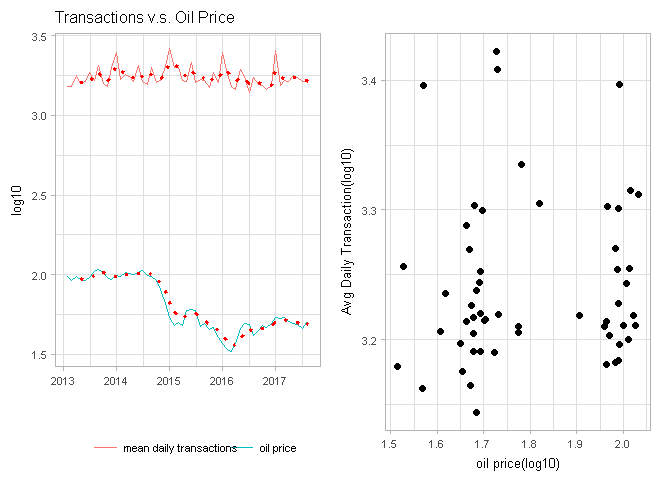

In [37]:
# Change periodicity from daily to monthly using to.period from xts
oil <- transactions %>%
 select(date, dcoilwtico) %>%
 distinct()

chartData <- transactions %>%
 select(date, transactions) %>%
 group_by(date) %>%
 summarize(total = mean(transactions)) %>%
 filter(date > '2013-01-01') %>%
 tq_transmute(
  select = total,
  mutate_fun = to.period,
  period = "months") %>%
 ungroup() %>%
 left_join(oil, by = "date")

chartDataMelt <- melt(chartData, id.vars = 'date')

chart1 <- chartDataMelt %>%
    ggplot(aes(x = date, 
               y = log10(value),
               color = variable,
               group = variable)) +
    geom_line() +
    #geom_point(col = palette_light()[1]) +
    geom_ma(ma_fun = EMA, n = 4, colour = "red", size = 1, linetype = 'dotted') + # SMA simple moving, EMA, exponentially weighted
    #geom_ma(ma_fun = SMA, n = 4, colour = "blue", size = 1, linetype = 'dotted') +  
    
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Transactions v.s. Oil Price", x = "", y = "log10", color = "")  +
    scale_color_hue(labels = c("mean daily transactions", "oil price")) +
    theme(text = element_text(size=8))

chart2 <- chartData %>%
    ggplot(aes(x = log10(dcoilwtico), 
               y = log10(total))) +
    geom_point() +
    labs(title = "", x = "oil price(log10)", y = "Avg Daily Transaction(log10)") +
    theme(text = element_text(size=8))
           
layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

### Do stores have similar seasonality in transaction volume over time?

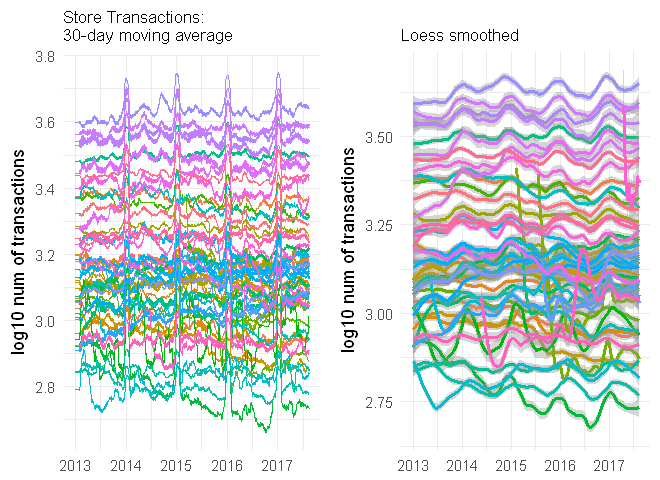

In [38]:
chartData <- transactions %>%
  select(date, store_nbr, transactions, movingAvg_7,movingAvg_15, movingAvg_30) %>%
  melt(id = c("date", 'store_nbr')) 

chart1 <- chartData %>%
  filter(variable == 'movingAvg_30') %>%
  ggplot(aes(x = date)) +
  geom_line(aes(y=log10(value), col= store_nbr)) +
  labs(title = "Store Transactions:\n30-day moving average",
       y = 'log10 num of transactions') +
  theme_minimal() +
  theme(legend.position="none", plot.title = element_text(size=10), axis.title.x=element_blank()) 
  
chart2 <- chartData %>%
  filter(variable == 'transactions') %>%
  ggplot(aes(x = date)) +
  geom_smooth(method = "loess", aes(y=log10(value), col= store_nbr), span = 0.2) +
  labs(title = "\nLoess smoothed",
       y = 'log10 num of transactions') +
  theme_minimal() + 
  theme(legend.position="none", plot.title = element_text(size=10), axis.title.x=element_blank())


layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

### Are stores generally growing or declining over time?

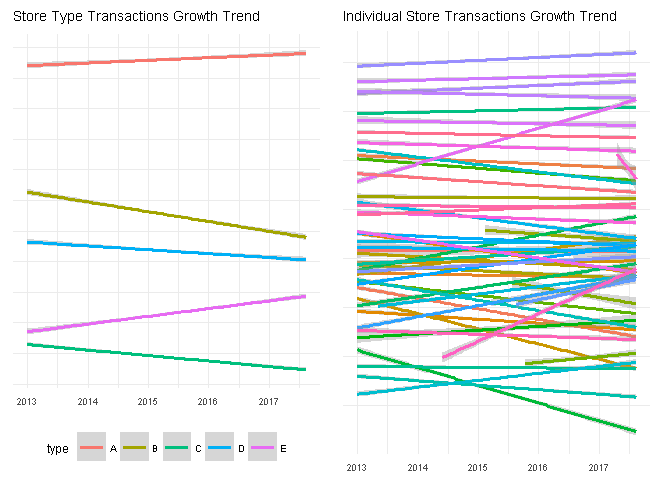

In [39]:
chartData <- transactions %>%
  select(date, store_nbr, transactions, type, movingAvg_30) %>%
  melt(id = c("date", 'store_nbr','type')) %>% 
  filter(variable == 'transactions')

chart1 <- chartData %>%
  ggplot(aes(x = date)) +
  geom_smooth(method = "gam", aes(y= log10(value), col= type)) +
  labs(title = "Store Type Transactions Growth Trend",
       y = 'number of transactions') +
  theme_minimal() +
  theme(axis.title.x= element_blank(),
        axis.text.y= element_blank(),
        axis.ticks.y= element_blank(),
        axis.title.y= element_blank(),
        text = element_text(size= 7),
        legend.position = 'bottom')


chartData <- transactions %>%
  select(date, store_nbr, transactions, movingAvg_30) %>%
  melt(id = c("date", 'store_nbr')) %>% 
  filter(variable == 'transactions')

chart2 <- chartData %>%
  ggplot(aes(x = date)) +
  geom_smooth(method = "gam", aes(y= log10(value), col= store_nbr)) +
  labs(title = "Individual Store Transactions Growth Trend",
       y = 'number of transactions') +
  theme_minimal() +
  theme(axis.title.x= element_blank(),
        axis.text.y= element_blank(),
        axis.ticks.y= element_blank(),
        axis.title.y= element_blank(),
        legend.position="none", 
        text = element_text(size= 7))

layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

### Are there more transactions on specific days of the week?

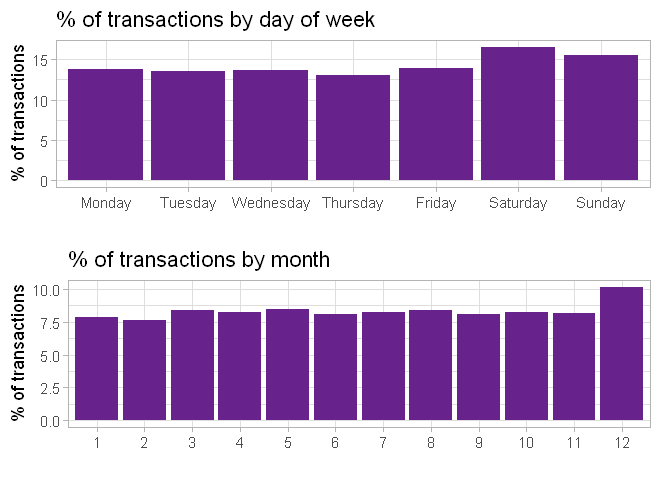

In [40]:
chartData <- transactions %>%
  mutate(weekday = weekdays(date)) %>%
  mutate(weekday = factor(weekday, 
                          levels= c("Monday", "Tuesday", "Wednesday", "Thursday", 
                                    "Friday", "Saturday", "Sunday"))) %>%
  group_by(weekday) %>%
  summarize(total = sum(transactions)) %>%
  mutate(percentage = total/sum(total)*100)
  
chart1 <- chartData %>%
  ggplot(aes(x = weekday,
             y = percentage)) + 
  geom_bar(stat = 'identity', fill = 'darkorchid4') +
  labs(x = '', y = '% of transactions', title = '% of transactions by day of week') 

chartData <- transactions %>%
  filter(date < "2017-01-01") %>%
  mutate(weekday = weekdays(date),
         month = factor(month(date))) %>%
  mutate(weekday = factor(weekday, 
                          levels= c("Monday", "Tuesday", "Wednesday", "Thursday", 
                                    "Friday", "Saturday", "Sunday"))) %>%
  group_by(month) %>%
  summarize(total = sum(transactions)) %>%
  mutate(percentage = total/sum(total)*100)
  
chart2 <- chartData %>%
  ggplot(aes(x = month,
             y = percentage)) + 
  geom_bar(stat = 'identity', fill = 'darkorchid4') +
  labs(x = '', y = '% of transactions', title = '% of transactions by month') 


layout <- matrix(c(1,2),2,1,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

### Zooming in on transactions by both day of week and month?

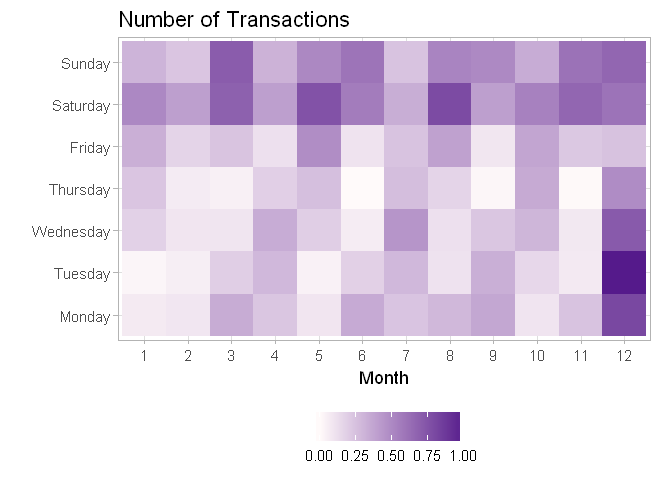

In [41]:
chartData <- transactions %>%
  filter(date < "2016-01-01") %>%
  mutate(weekday = weekdays(date),
         month = factor(month(date))) %>%
  mutate(weekday = factor(weekday, 
                          levels= c("Monday", "Tuesday", "Wednesday", "Thursday", 
                                    "Friday", "Saturday", "Sunday"))) %>%
  group_by(weekday, month) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  mutate(percentage = total/sum(total)*100) %>%
  mutate(normalized = (percentage - min(percentage)) / (max(percentage) - min(percentage)))
         

chart <- chartData %>%
  ggplot(aes(month, weekday, fill = normalized)) +
  geom_tile() +
  labs(title = 'Number of Transactions', x = "Month", y = "") +
  scale_fill_gradient(low = 'snow', high= 'purple4')   +
  theme(legend.title=element_blank())

chart



### Are there more transactions on holidays / paydays?

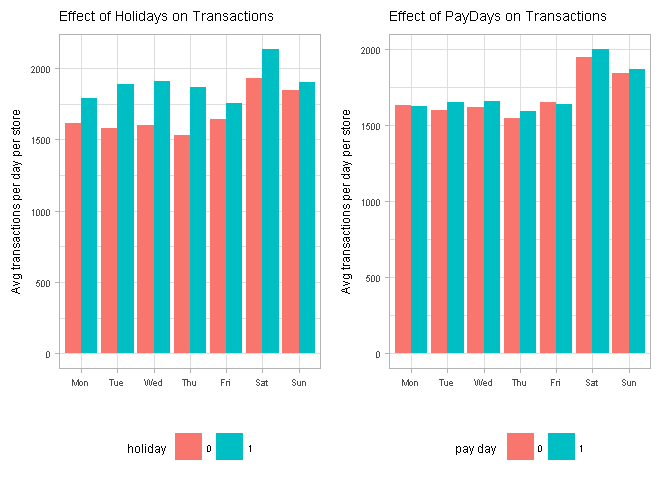

In [42]:
chartData <- transactions %>%
 select(date, holidayFlag, payDay, transactions) %>%
 mutate(weekday = weekdays(date, abbreviate = TRUE)) %>%
 group_by(weekday, holidayFlag) %>%
 summarize(mean = mean(transactions)) %>%
 mutate(holidayFlag = as.character(holidayFlag)) %>%
 ungroup() %>%
 mutate(weekday = factor(weekday, 
                          levels= c("Mon", "Tue", "Wed", "Thu", 
                                    "Fri", "Sat", "Sun")))

chart1 <- chartData %>%
  ggplot(aes(x = weekday,
             y = mean)) + 
  geom_bar(aes(fill = holidayFlag), stat = 'identity', position="dodge") +
  labs(x = '', 
       y = 'Avg transactions per day per store', 
       title = 'Effect of Holidays on Transactions', 
       fill = "holiday") +
  theme(text = element_text(size= 7))

chartData <- transactions %>%
 select(date, holidayFlag, payDay, transactions) %>%
 mutate(weekday = weekdays(date, abbreviate = TRUE)) %>%
 group_by(weekday, payDay) %>%
 summarize(mean = mean(transactions)) %>%
 mutate(payDay = as.character(payDay)) %>%
 ungroup() %>%
 mutate(weekday = factor(weekday, 
                          levels= c("Mon", "Tue", "Wed", "Thu", 
                                    "Fri", "Sat", "Sun")))
chart2 <- chartData %>%
  ggplot(aes(x = weekday,
             y = mean)) + 
  geom_bar(aes(fill = payDay), stat = 'identity', position="dodge") +
  labs(x = '', 
       y = 'Avg transactions per day per store', 
       title = 'Effect of PayDays on Transactions', 
       fill = "pay day") +
  theme(text = element_text(size= 7))

layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

### Does an item have similar sales trend in different stores?

Warning message in log(total):
"NaNs produced"Warning message in log(total):
"NaNs produced"

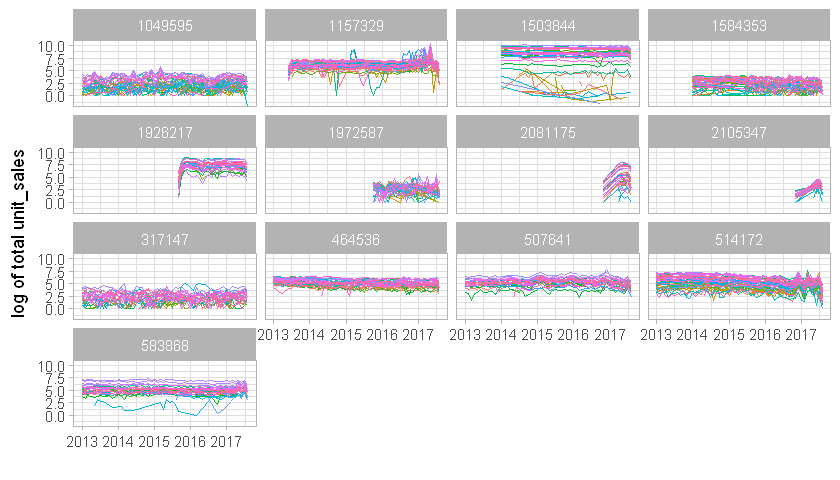

In [44]:
chartData <- subsetItems %>%
  select(yymm1,store_nbr, unit_sales, item_nbr) %>%
  group_by(yymm1, store_nbr, item_nbr) %>%
  summarize(total = sum(unit_sales))


options(repr.plot.width= 7, repr.plot.height= 4)
chart <- chartData %>%
  ggplot(aes(x = yymm1, 
             y = log(total), 
            col = store_nbr)) +
  geom_line() +
  facet_wrap(~ item_nbr) +
  theme(legend.position="none") +
  labs(x = '', 
       y = 'log of total unit_sales')

chart
options(repr.plot.width= 5.5, repr.plot.height= 4)



### Focusing on the sales trend of a single item to understand possible divergence

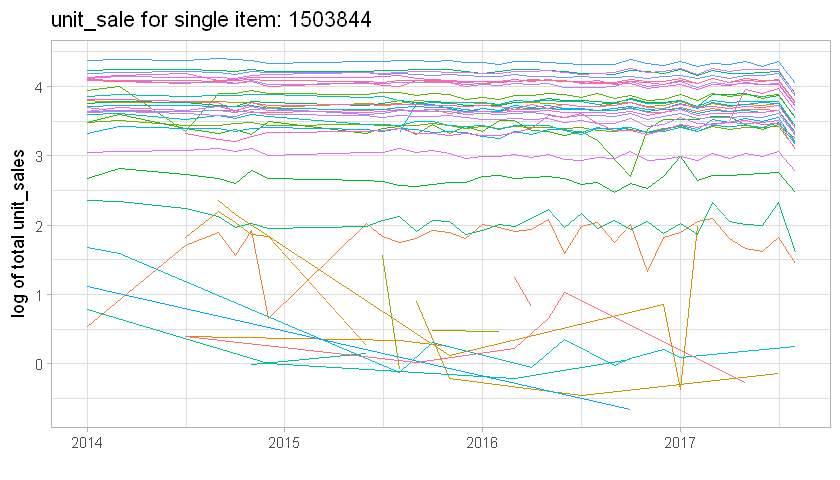

In [45]:
chartData <- subsetItems %>%
  filter(item_nbr == "1503844") %>%
  select(yymm1, store_nbr, unit_sales) %>%
  group_by(yymm1, store_nbr) %>%
  summarize(total = sum(unit_sales))

options(repr.plot.width= 7, repr.plot.height= 4)
chart <- chartData %>%
  ggplot(aes(x = yymm1, 
             y = log10(total), 
            col = store_nbr)) +
  geom_line() +
  theme(legend.position="none") +
  labs(title = 'unit_sale for single item: 1503844',
       x = '', 
       y = 'log of total unit_sales')

chart
